This demo starts with reading in raw single-cell RNA seq data and walks through the pre-processing steps. The bulk ATAC data here has been preprocessed and the input is a set of differential-accessible peaks across all clusters.

In [14]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scanpy
import pickle
from tqdm import tqdm
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Colors for each cluster
# This palette can be custom made
palette= {0:"#17154f", 
          1: "#3b5bad", 
          2: "#b0799a", 
          7: "#9d9cd5", 
          9: "#2f357c", 
          10: "#e69b00", 
          12: "#8eb87f", 
          14: "#bf3729", 
          15: "#f6b3b0"}

# Reading in Data

In [4]:
normal_peaks=pd.read_csv("/demo_data/regeneration/regeneration_differential_peaks.bed", sep='\t', header=None)[[0,1,2]]
normal_peaks.columns = ['chrom','chromStart','chromEnd']
width=normal_peaks['chromEnd']-normal_peaks['chromStart']
normal_peaks=normal_peaks.iloc[np.where(width<2000)]
normal_peaks

,chrom,chromStart,chromEnd
2,chr7,12774451,12775054
3,chr2,85093270,85094452
4,chr15,100699353,100699836
5,chr12,40224231,40225080
6,chr10,75495308,75496340
...,...,...,...
7623,chr19,28037074,28037660
7624,chrX,7420885,7421558
7625,chr1,88357474,88358386
7626,chr4,116167350,116167892


In [6]:
# read in scRNAseq data
X = scanpy.read_h5ad("/demo_data/regeneration/regeneration_adata_normalized.h5ad")
X

AnnData object with n_obs × n_vars = 5501 × 16826
    obs: 'batch', 'total_molecules', 'condition', 'cluster'
    obsm: 'X_EMBED', 'X_PCA', 'X_fdl'

In [7]:
# make sure all the columns are nonzero!! This is very important for constraints
nonzero_columns=np.where(~np.all(X.X.toarray() == 0, axis = 0))[0]
X = X[:,nonzero_columns]

In [8]:
X.obsm['X_pca']=X.obsm['X_PCA']
# note that this data has already been normalized to median library size so we'll not normalize again
# still need to log transform the data
# will require data to have finished preprocessing in any input for the package
# log transform data
scanpy.pp.log1p(X)

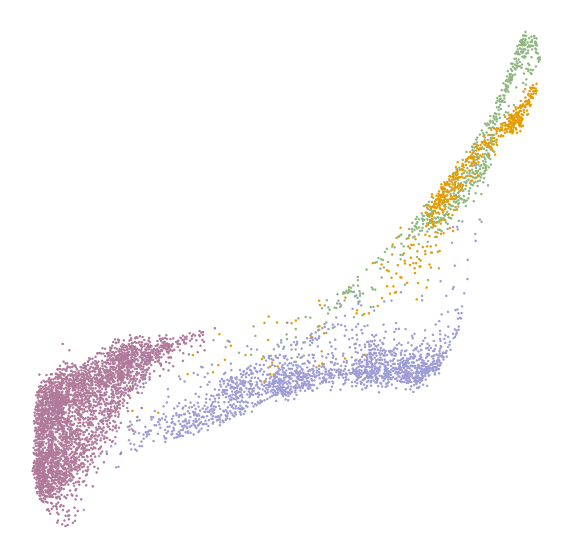

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X.obsm['X_fdl'][:,0],X.obsm['X_fdl'][:,1],s=2,c=[palette[i] for i in X.obs['cluster'].to_list()])
ax.set_axis_off()

# Building GRN

In [43]:
from sckinetics import tf_targets
from sckinetics import atac_processing_utils

In [9]:
#full wrapper to:
    #install R packages, if not installed
    #download and load genome into memory
    #load motif files
peak_annotation = tf_targets.PeakAnnotation(adata=X,genome='mm10')

Starting peak annotation. Make sure the X matrix in adata has been log transformed.
Checking R packages are installed ...
 
Finished setting up R packages
Loading genome (this make take a while!) ...


Loading motifs ...


In [10]:
# the wrapper function for all the steps until G clusters
peak_annotation.call_motifs(normal_peaks,pvalue=1e-10)

Calling motifs with default settings...
Annotating peaks
Running ChIPSeeker ...
>> preparing features information...		 2022-12-14 05:04:25 PM 
>> identifying nearest features...		 2022-12-14 05:04:26 PM 
>> calculating distance from peak to TSS...	 2022-12-14 05:04:27 PM 
>> assigning genomic annotation...		 2022-12-14 05:04:27 PM 
>> assigning chromosome lengths			 2022-12-14 05:04:49 PM 
>> done...					 2022-12-14 05:04:49 PM 
Converting gene annotations ...
Filtering genes ...
Extracting peak sequence...
1433Computing background...


100%|█████████████████████████████████████| 359/359 [00:00<00:00, 169147.96it/s]

Scanning peaks...


 Peak 358 in fourth quantileFinished peak scanning. Compiling all data (this might take a while!!)

Filtering genes...
Formatting pairs... (this might take a while!)

Finished motif calling.


In [11]:
#if running for distinct cell types, iterate over cell -type marker peaks
#input to velocity algorithm should require dictionary of G matrices indexed by cluster annotation
G_clusters = {}
for this_cluster in tqdm(list(set(X.obs['cluster']))):
    #computes G for each cluster, which is a dictionary storing a target annotation
    #each target's TFs can be accessed as G[target_name].transcription_factors
    #indices in the count matrix are stored in G[target_name].target_index, and .transcription_factors_index
    #the corresponding imputed, scaled count matrix is added to peak_annotation.adata.obsm as "X_cluster"
    #cluster_peaks_filtered = np.intersect1d(peak_annotation.pairs.index,cluster_peaks[cluster])
    G_clusters[this_cluster] = peak_annotation.prepare_target_annotations(cluster_key='cluster',
                                                                    cluster=this_cluster)
    
    
    #peak_annotation.adata.uns['X_HSC] -> X_

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Starting MAGIC imputation
Creating Kernel
Creating Markov Matrix
MAGIC Imputing


100%|█████████████████████████████████████████████| 4/4 [05:07<00:00, 76.82s/it]


In [12]:
# # saving everything we need for EM
pickle.dump(peak_annotation.adata, open("demo_data/regeneration/adata_prepared_1214.h5ad", 'wb'))
pickle.dump(G_clusters,open("demo_data/regeneration/G_1214.dict",'wb'))

In [50]:
##Reading in data for EM
adata = pickle.load(open("demo_data/regeneration/adata_prepared_1214.h5ad",'rb'))
G_clusters=pickle.load(open("demo_data/regeneration/G_1214.dict", 'rb'))

# EM

In [51]:
%load_ext autoreload
%autoreload 2
from sckinetics import EM_new

import time
model = EM_new.ExpectationMaximization_new(threads=15, maxiter=20)

start = time.time()

model.fit(adata, G_clusters, celltypes_basis = "cluster")

end = time.time()
print("time")
print(end - start)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Successfully initiated EM model.
Number of CPUs: 72.
Running on 15 threads.
Total number of cells: 5501
Cell types: 10, 2, 12, 7
Start calculating priors.
Getting priors for: 10
Getting priors for: 2
Getting priors for: 12
Getting priors for: 7
Start calculating constraints.
5500
Finished getting all constraints.
Running main EM algorithm for for: 10
Total number of targets: 1339


Celltype 10 on 15 batches: 100%|████████████████| 15/15 [11:43<00:00, 46.90s/it]


Running main EM algorithm for for: 2
Total number of targets: 1339


Celltype 2 on 15 batches: 100%|█████████████████| 15/15 [21:17<00:00, 85.17s/it]


Running main EM algorithm for for: 12
Total number of targets: 1339


Celltype 12 on 15 batches: 100%|████████████████| 15/15 [11:46<00:00, 47.11s/it]


Running main EM algorithm for for: 7
Total number of targets: 1339


Celltype 7 on 15 batches: 100%|█████████████████| 15/15 [16:19<00:00, 65.29s/it]


Finished ATACVelo calculation.
time
4408.065995454788


In [52]:
pickle.dump(model,open("demo_data/regeneration/model_1214.pickle",'wb'))

# Plotting visualizations

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from sckinetics import graph_embedding
from sckinetics import VelocityGraph

In [7]:
# Re-reading in data
model=pickle.load(open("demo_data/regeneration/model_1214.pickle",'rb'))
adata=model.adata

In [29]:
np.count_nonzero(np.isnan(model.A_[10]))

0

In [27]:
embedding=adata.obsm['X_fdl']

vg = VelocityGraph(model, knn=30)
vg.create_velocity_graph()
vg.compute_transitions()
velocity_embedding = vg.embed_graph(embedding)

100%|███████████████████████████████████████| 5501/5501 [07:53<00:00, 11.63it/s]


<AxesSubplot:>

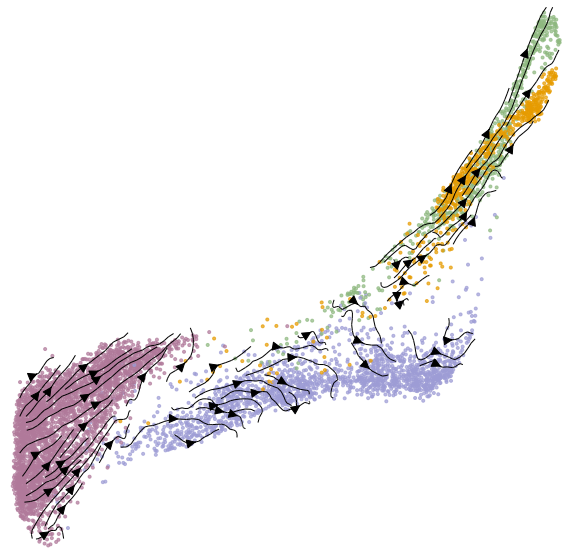

In [32]:
celltypes_colors=[palette[i] for i in adata.obs['cluster']]
graph_embedding.embedding_stream(embedding,velocity_embedding,density=3, 
                arrowsize=2, s=9, linewidth=1, cluster_color=[palette[i] for i in adata.obs['cluster'].to_list()])

In [17]:
from scvelo.tools.utils import *
from scvelo.tools.velocity_embedding import quiver_autoscale
from scvelo.plotting.velocity_embedding_grid import compute_velocity_on_grid

def embedding_stream_subset(embedding,adata, celltype,celltype_basis,V_emb=velocity_embedding,figsize=(5,5),density=2, arrowsize=1, 
                     s=4, linewidth=1, cluster_color=pd.Series(celltypes_colors), stream_color='black', alpha=0.7):
    subset_index=np.where(adata.obs[celltype_basis]==celltype)
    x = embedding[subset_index, 0]
    y = embedding[subset_index, 1]
    X_grid, V_grid = compute_velocity_on_grid(X_emb=embedding[subset_index], V_emb=V_emb[subset_index],
                       density=density,n_neighbors=30,autoscale=False, adjust_for_stream=True)
    fig,ax = plt.subplots(figsize=figsize)
    ax.streamplot(X_grid[0], X_grid[1], V_grid[0], V_grid[1], 
                   zorder=1, density=density,color=stream_color,#color=V_grid[1],
                  arrowsize=arrowsize,linewidth=linewidth)#,cmap='hot')
    cluster_color=pd.Series(celltypes_colors)
    ax.scatter(x=embedding[subset_index, 0], y=embedding[subset_index, 1], zorder=0, s=s, c=cluster_color.loc[subset_index], alpha=alpha)
    ax.set_title(celltype)
    ax.axis("off");
    return ax

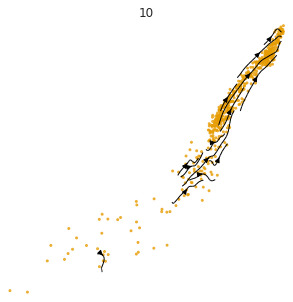

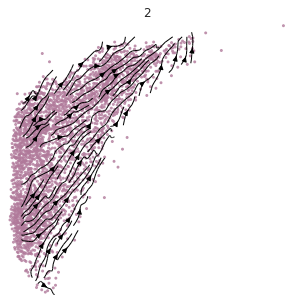

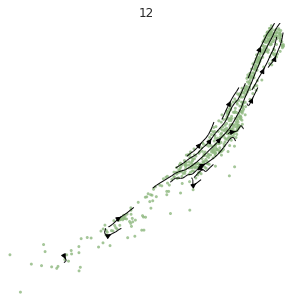

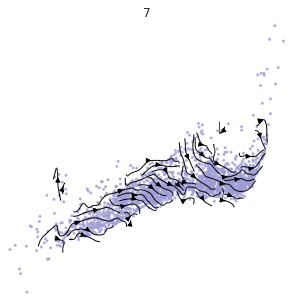

In [33]:
celltype_basis='cluster'
for celltype in set(adata.obs[celltype_basis]):
    embedding_stream_subset(embedding,adata,celltype, celltype_basis)

In [12]:
#function to plot graph edges between points on a 2D embedding
from matplotlib.collections import LineCollection
def plot_G_weighted_edges(tsne, G, adata,alpha_G=1, s=10, t='k' ,figsize=(15,15),
                    cmap='viridis', ax=None,scale=0.1):
    #set up the figure
    fig,ax = plt.subplots(figsize=figsize)
    #collect the points for each segment
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    #collect line widths
    colors = [G[i, j] for (i, j) in G.todok().keys() if i < j]
    #plot line segments
    ax.add_collection(LineCollection(segments,colors='b',
                                     alpha=alpha_G,
                                     linewidths=np.array(colors)*scale))
    #plot points, colored by t value
    ax.scatter(tsne[:,0],tsne[:,1], marker='o',s=s,c=[palette[i] for i in adata.obs['cluster'].to_list()],cmap=cmap,zorder=2)
    ax.set_axis_off()
    return ax

<AxesSubplot:>

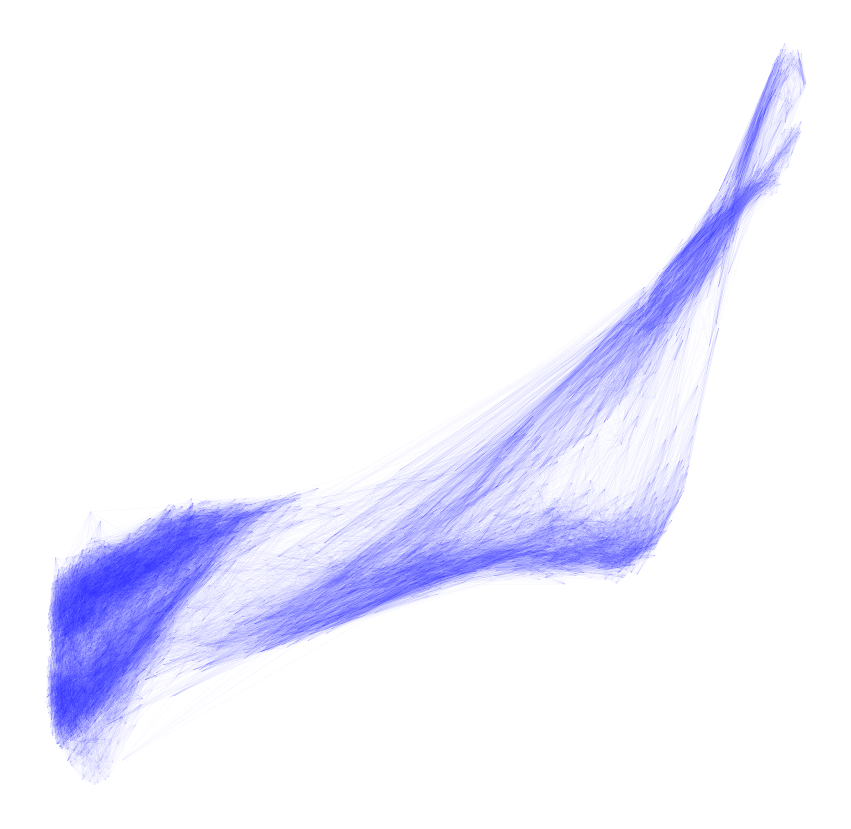

In [34]:
plot_G_weighted_edges(adata.obsm['X_fdl'],vg.graph,adata, alpha_G=0.1, s=0, scale=0.2)

# Testing the Markov Chain (0910, with the jaccard kNN graph)

## Forward direction from the most acinar cell

In [35]:
transition_matrix=vg.T.toarray().astype(np.float32)

In [36]:
np.savetxt("demo_data/regeneration/transition_matrix.csv", transition_matrix, delimiter = ",")

In [ ]:
# chosen cell is from cellrank
#chosen_cell='195622430161196_DACD511_Kate_plus'
chosen_cell='191774126980316_DACD550_kate_plus'
x0=np.zeros(5501)
x0[adata.obs_names.to_list().index(chosen_cell)]=1
import copy
adata_timestep=copy.deepcopy(adata)
adata_timestep.obs[0]=x0

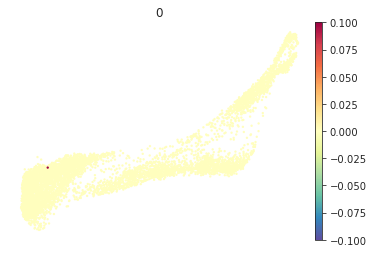

In [11]:
scanpy.pl.embedding(adata_timestep, basis='X_fdl', color=[0], 
                    vmin = 'p1', vmax = 'p99', frameon=False, cmap='Spectral_r')

In [12]:
times=[1,10,100,200,1000, 2000,5000,10000, 20000, 30000]

for time in times:
    this_x0=x0.copy()
    for i in range(time):
        this_x0=this_x0.dot(transition_matrix)
    adata_timestep.obs[time]=this_x0

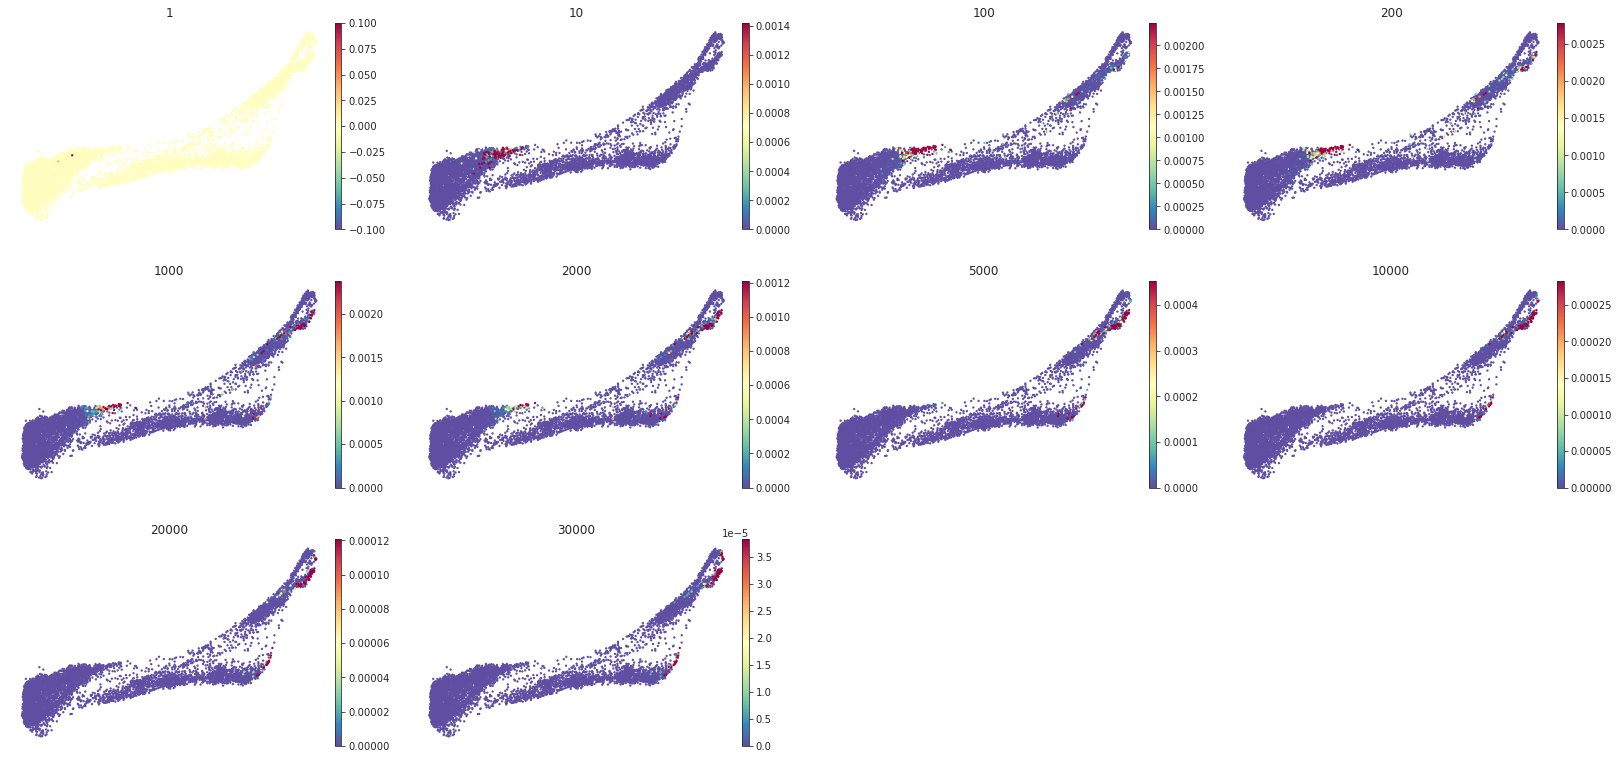

In [13]:
# This is results with jaccard, this is not the actual cell from the next step
scanpy.pl.embedding(adata_timestep, basis='X_fdl', color=[1,10,100,200,1000, 2000,5000,10000, 20000, 30000], 
                    vmin = 'p1', vmax = 'p99', frameon=False, cmap='Spectral_r')

## Creating a heatmap for a cell's trajectory (for paper)

In [10]:
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# now use diffusion components to re-order the cells
scanpy.pp.neighbors(adata)
scanpy.tl.diffmap(adata)

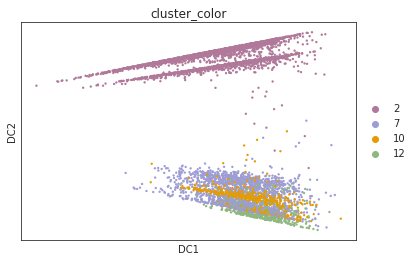

In [12]:
adata.obs['cluster_color']=[str(x) for x in adata.obs['cluster'].to_list()]
scanpy.pl.diffmap(adata, color='cluster_color', palette={'0':"#17154f", 
          '1': "#3b5bad", 
          '2': "#b0799a", #left
          '7': "#9d9cd5", # one end
          '9': "#2f357c", 
          '10': "#e69b00", 
          '12': "#8eb87f", 
          '14': "#bf3729", 
          '15': "#f6b3b0"})

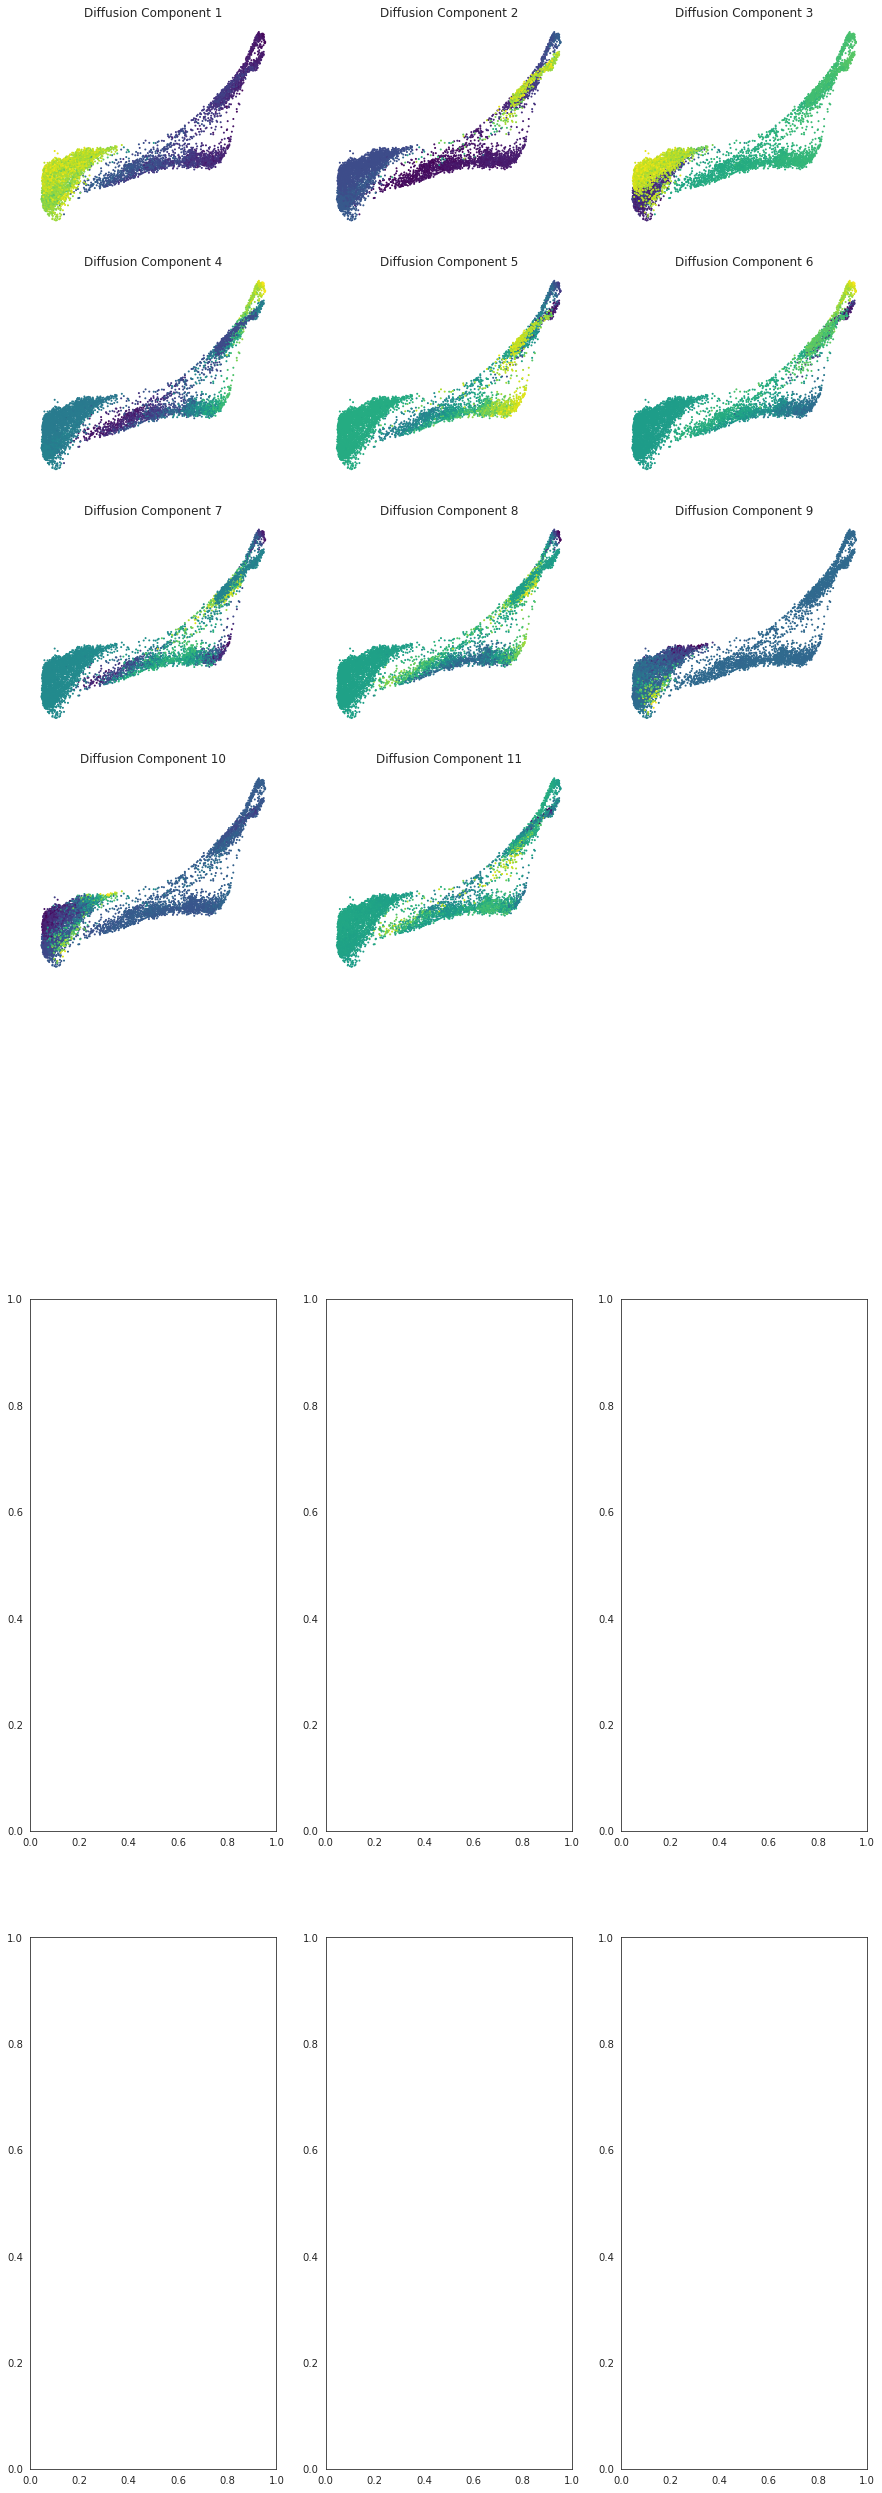

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(15, 45), sharey=False)
i, j=0,0
for i in np.arange(1,12):
    plt.subplot(10, 3, i)
    plt.scatter(adata.obsm['X_fdl'][:,0],adata.obsm['X_fdl'][:,1],s=1, c=adata.obsm["X_diffmap"][:,i], cmap='viridis')
    plt.title("Diffusion Component "+str(i))
    plt.axis('off')
plt.show()

In [14]:
DC1=adata.obsm['X_diffmap'][:,1]

In [15]:
#the most acinar cell
adata.obs_names[np.argmax(DC1)]

'191774126980316_DACD550_kate_plus'

In [16]:
#the most ductal cell
adata.obs_names[np.argmin(DC1)]

'134539692369758_DAC_B530-Kate+'

In [23]:
chosen_cell='191774126980316_DACD550_kate_plus'

x0=np.zeros(5501)
x0[adata.obs_names.to_list().index(chosen_cell)]=1

times=[0,1,2,5,10,15, 20,50,100,150,300, 500, 700,1000,1500, 2000, 5000, 7000, 10000, 15000, 20000, 30000]
markov_timestep=np.zeros((len(times), 5501))
j=0
for time in times:
    this_x0=x0.copy()
    for i in range(time):
        this_x0=this_x0.dot(transition_matrix)
    markov_timestep[j]=this_x0
    j+=1
    
markov_df_jaccard=pd.DataFrame(markov_timestep, index=times, columns=adata.obs['cluster'].tolist())

In [24]:
reorganized_markov=markov_df_jaccard.iloc[:,np.flip(np.argsort(DC1))]

In [25]:
reorganized_markov

,2,2,2,2,2,2,2,2,2,2,...,7,12,12,12,12,7,12,12,12,12
0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2.647232e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,1.180155e-07,6.588614e-20,3.579633e-14,2.041924e-12,2.925950e-10,6.564717e-14,3.327505e-13,1.972065e-18,5.316843e-05,9.503160e-19,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10,7.647223e-13,3.102896e-15,4.025725e-15,6.624740e-12,2.915302e-11,2.263488e-14,2.988554e-06,5.214716e-16,1.497944e-05,2.630163e-20,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
15,8.259790e-15,1.761419e-14,3.166504e-15,1.066424e-12,2.781160e-11,2.749513e-14,5.048456e-06,6.954488e-17,5.192625e-06,4.486879e-20,...,1.310782e-33,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.165889e-40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
20,5.159451e-15,7.050036e-15,7.538808e-16,6.730314e-13,6.216798e-12,1.320058e-14,6.804190e-06,5.122265e-17,3.735769e-06,8.226778e-21,...,4.114425e-23,2.362467e-22,7.553679e-24,1.872466e-25,1.316567e-27,1.840642e-25,4.381218e-22,6.376266e-23,1.756705e-21,2.769538e-23
50,2.065569e-16,6.841257e-15,8.957731e-17,1.228180e-15,1.590966e-13,4.095492e-15,6.816501e-06,2.059823e-19,1.600656e-07,2.374470e-23,...,4.398613e-13,1.754142e-09,1.206314e-10,1.250837e-10,1.748196e-15,1.973023e-15,1.913702e-09,1.959779e-09,2.335259e-10,4.756132e-10
100,8.413647e-18,2.935115e-15,7.136465e-16,8.131211e-18,6.134527e-14,1.506826e-15,5.861622e-06,8.105557e-20,2.225012e-08,7.716306e-26,...,2.782281e-12,1.622129e-07,6.369802e-09,2.539882e-09,1.858594e-14,1.248523e-14,1.859603e-07,1.928001e-07,3.198914e-09,4.803025e-08
150,7.242767e-18,1.169322e-15,1.275239e-15,3.320384e-18,2.443597e-14,5.940996e-16,5.337119e-06,8.809201e-20,2.798949e-08,3.052952e-26,...,4.636892e-12,5.516902e-07,1.976890e-08,5.297546e-09,2.743284e-14,2.080284e-14,6.347806e-07,6.589541e-07,7.593022e-09,1.651838e-07


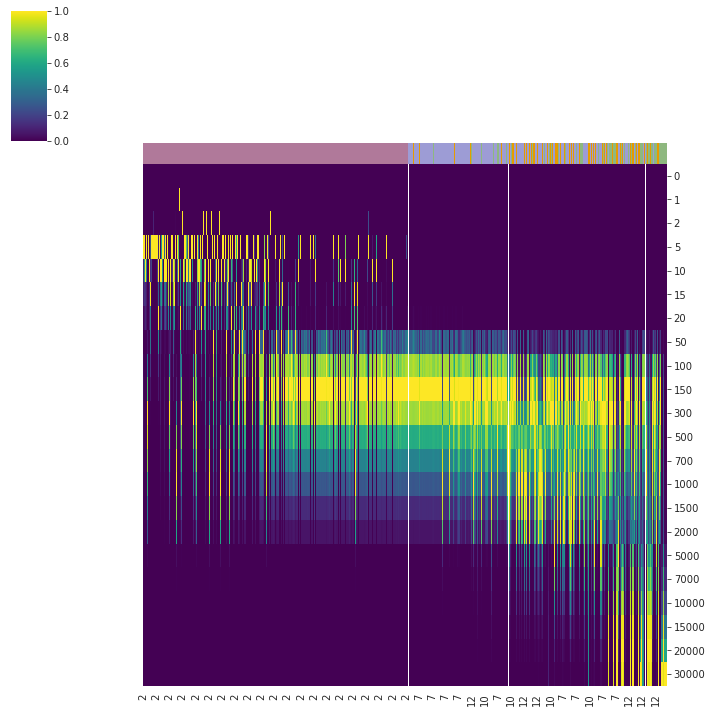

In [26]:
# need to try to find a way to do row-specific scaling, or like cmap applies to each row
sns.clustermap(reorganized_markov, col_cluster=False, row_cluster=False,
               col_colors=[palette[i] for i in reorganized_markov.columns.tolist()],z_score=None,
               cmap='viridis', standard_scale=1)